# 1.0 Introduction

We analyze a collection of 116,909 Colombia event mentions between 09/11/2016 and 06/17/2017 collected from GDELT's Mentions (<em>[gdelt-bq:gdeltv2.eventmentions]</em>) table. The Mentions table records each mention of an event in the Events table, making it possible to track the trajectory and network structure of a story as it flows through the global media system. Each mention of an event receives its own entry in the Mentions table, therefore an event that is mentioned in 100 articles will be listed 100 times in the Mentions table. <em>If a news report mentions multiple events, each mention is recorded separately in this table.</em> As each event mention is recorded over time, along with the timestamp the article was published,users can track the progression of an event through the global media, identifying outlets that tend to break certain kinds of events the earliest or which may break stories later but are more accurate in their reporting on those events. Combined with the 15 minute update resolution and GCAM, the Mentions table also allows the emotional reaction and resonance of an event to be assessed as it sweeps through the world’s media. We begin by identifying the most prominent media type and languages for all event mentions, then we computer the event tone and confidence distribution for all event mentions in the data set. We then identify the dominant sources with the Top 50 event mention frequencies, filter the sources relevant to the Peace Accords Matrix (PAM) implementation monitoring and verification framework, and compare their language composition as well as tone and confidence distributions.

In [1]:
# Import useful libraries
import re
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from math import isnan
from collections import Counter
from collections import OrderedDict 
from sklearn.neighbors.kde import KernelDensity
from NewspaperLanguages import translations
# Declare global options
%matplotlib inline 
pd.set_option('display.max_colwidth', -1)
plt.style.use('seaborn-whitegrid')
# Declare global variables
all_mentions = pd.read_csv('C:/Users/Administrator/Dropbox/GDELT/all_mentions.csv', encoding='latin-1').sort_values('EventTimeDate', ascending=1)
all_mentions.columns

Index(['GLOBALEVENTID', 'EventTimeDate', 'MentionTimeDate', 'MentionType',
       'MentionSourceName', 'MentionIdentifier', 'SentenceID',
       'Actor1CharOffset', 'Actor2CharOffset', 'ActionCharOffset', 'InRawText',
       'Confidence', 'MentionDocLen', 'MentionDocTone',
       'MentionDocTranslationInfo', 'Extras'],
      dtype='object')

# 2.0 Media Analysis

As an event is mentioned across multiple news reports, each of those mentions is recorded in the Mentions table, along with several key indicators about that mention, including the media type mentioning the event, the average "tone" of the news report mentioning the event, and the "confidence" of GDELT's algorithms in their identification of the event
from that specific news report. The following section identifies the most prominent media type (WEB) and languages (English and Spanish) as well as the average tone and confidence distributions for the collection of source documents in the Mentions table.

## 2.1 Mention Types

The MentionTypes field is a numerical identifier that refers to the source collection that the document originated from:

1: WEB - The document originates from the open web and the MentionIdentifier is a fully-qualified URL that can be used to access the document on the web

2: CITATIONONLY - The document originates from a broadcast, print, or other offline source in which only a textual citation is available for the document.  In this case the MentionIdentifier contains the textual citation for the document

3: CORE - The document originates from the CORE archive and the MentionIdentifier contains its DOI, suitable for accessing the original document through the CORE website

4: DTIC - The document originates from the DTIC archive and the MentionIdentifier contains its DOI, suitable for accessing the original document through the DTIC website

5: JSTOR - The document originates from the JSTOR archive and the MentionIdentifier contains its DOI, suitable for accessing the original document through your JSTOR subscription if your institution subscribes to it

6: NONTEXTUALSOURCE - The document originates from a textual proxy (such as closed captioning) of a non-textual information source (such as a video) available via a URL and the MentionIdentifier provides the URL of the non-textual original source.  At present, this Collection Identifier is used for processing of the closed captioning streams of the Internet Archive Television News Archive in which each broadcast is available via a URL, but the URL offers access only to the video of the broadcast and does not provide any access to the textual closed captioning used to generate the metadata.  This code is used in order to draw a distinction between URL-based textual material (Collection Identifier 1 (WEB) and URL-based non-textual material like the Television News Archive.

In [2]:
# Preprocessing: Mention Type Codes
MentionTypes = Counter(all_mentions.MentionType)

MentionTypeCodes = {1: "WEB",
                   2: "CITATIONONLY",
                   3: "CORE",
                   4: "DTIC",
                   5: "JSTOR",
                   6: "NONTEXTUALSOURCE"}

MentionTypes = OrderedDict(sorted(MentionTypes.items(), key=lambda x: x[1], reverse=True))
mention_type_labels = [MentionTypeCodes[key] for key in list(MentionTypes.keys())]
mention_type_sizes = list(MentionTypes.values())
print(MentionTypes)

OrderedDict([(1, 116787), (2, 122)])


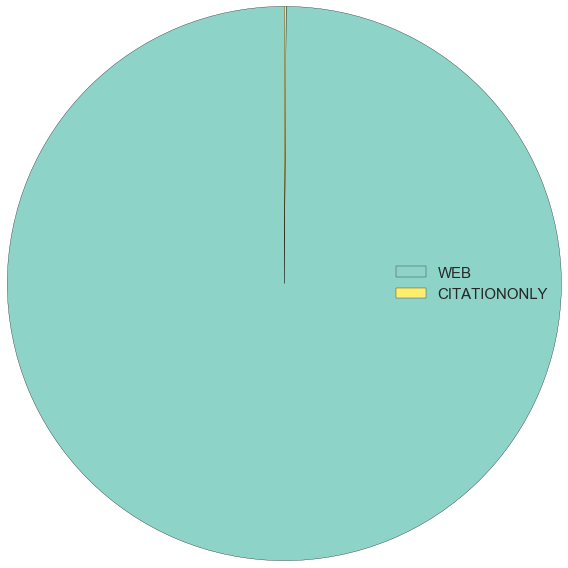

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))
patches, texts = plt.pie(mention_type_sizes, colors=cm.Set3(np.linspace(0, 1, len(mention_type_labels))), startangle=90)
plt.legend(patches, mention_type_labels, loc="right", fontsize=15)
plt.axis('equal')
plt.tight_layout()
plt.show()

## 2.2 Media Languages

GDELT provides realtime translation of the world’s news in 65 languages. The Mentions Document Translation Information (MentionDocTranslationInfo) field records the provenance information for machine-translated documents indicating the original source language and the citation of the translation system used to translate the document for processing. The field will be null for documents originally in English. The field will also be null for human-translated documents and provided to GDELT in English, such as BBC Monitoring materials. In the future, this field may be expanded to included information on human-translated pipelines. To analyse the language composition of the mentions documents collection, we begin by preprocessing the MentionDocTranslationInfo values to normal language names and append the clean language named to the DataFrame for further analysis.

In [4]:
# Preprocessing: Mention Document Languages
languages = []

for lang in all_mentions.MentionDocTranslationInfo:
    try:
        languages.append(translations[lang][1])
    except:
        languages.append('English')

all_mentions['Language'] = languages
languages = Counter(languages)
print(languages)
languages = OrderedDict(sorted(languages.items(), key=lambda x: x[1], reverse=True))
language_labels = [key for key in list(languages.keys())]
language_sizes = list(languages.values())

Counter({'English': 56400, 'Spanish': 50211, 'French': 2885, 'Portuguese': 2191, 'Other': 2107, 'German': 1202, 'Arabic': 900, 'Russian': 392, 'Italian': 294, 'Danish': 142, 'Norwegian': 111, 'Swedish': 70, 'Hungarian': 2, 'Hebrew': 2})


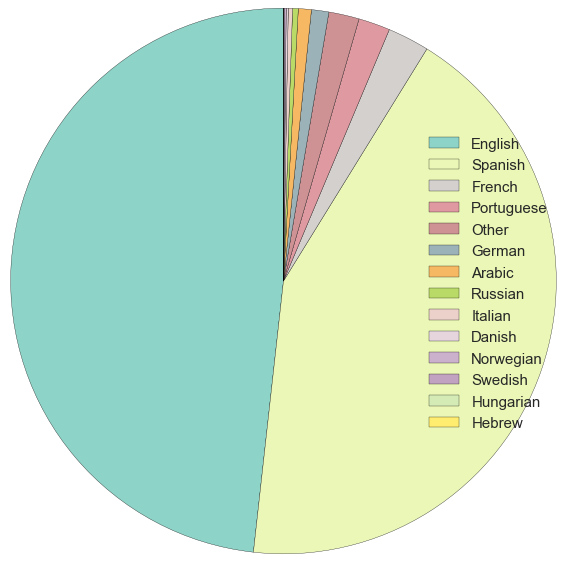

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
patches, texts = plt.pie(language_sizes, colors=cm.Set3(np.linspace(0, 1, len(language_sizes))), startangle=90)
plt.legend(patches, language_labels, loc="right", fontsize=15)
plt.axis('equal')
plt.tight_layout()
plt.show()

## 2.3 Tone Distribution

In this section, we analyze the average tone distribution for all source documents in the Mentions Table. Although the score ranges from -100 (extremely negative) to +100 (extremely positive), common values range between -10 to +10, with 0 indicating a neutral tone. The MentionDocTone field can be used to filter event "contexts" as an implicit measure of the importance of an event or as a proxy indicator for the impact of an event. For example, a riot event with slightly negative average tone is more likely to be a minor occurence compared to one with extremely negative average tone. However, it is important to note that the MentioDocTone indicator only provides a basic tonal assessment of an article. It is recommended that users interested in emotional measures use the Mentions and Global Knowledge Graph (GKG) tables to merge the complete 2,300 emotions and themes from the GKG Global Content Analysis Measures (GCAM) system into their analysis.

In [6]:
# Preprocessing: Mention Document Tone
tone = np.array(list(all_mentions.MentionDocTone))
print(all_mentions.MentionDocTone.describe())

count    116909.000000
mean    -0.860289     
std      3.701209     
min     -17.821782    
25%     -3.225806     
50%     -0.847458     
75%      1.636905     
max      23.333333    
Name: MentionDocTone, dtype: float64


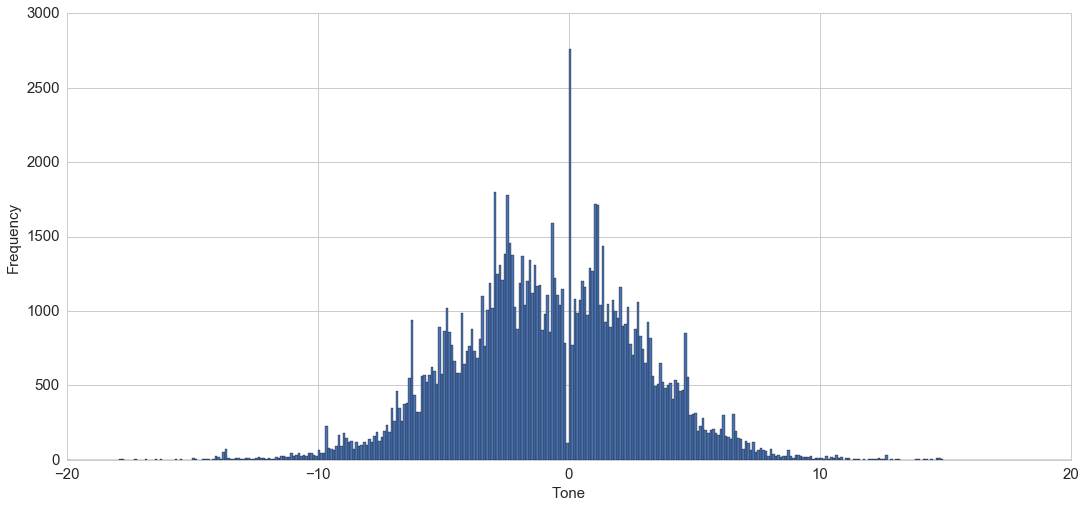

In [7]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.hist(tone, bins=500, range=(-20,30), histtype='bar', align='mid', orientation='vertical')
ax.set_title('', fontsize=15, fontweight='bold')
ax.set_ylabel('Frequency' , fontsize=15)
ax.set_xlabel('Tone', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xticks(np.arange(-20, 50, 10))
plt.xlim([-20,20])
plt.show()

## 2.4 Daily Tone Timeseries

In addition to the global tone distribution, we analysed the daily average tone for all mentions. Due to daily fluctuations in mention documents tone, we also computed the 7-day simple moving average:

$$SMA = \frac{a_{m} + a_{m-1} + ... + a_{m-(n-1)}}{n}$$

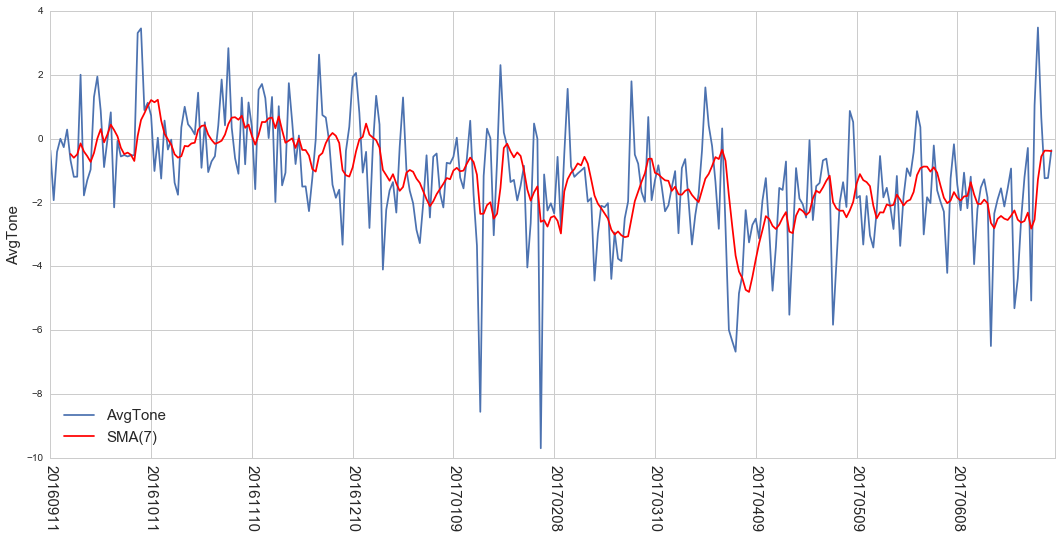

In [8]:
all_mentions['MentionDates'] = [str(date)[:8] for date in all_mentions['MentionTimeDate']]

dates = sorted([key for key in Counter(all_mentions['MentionDates']).keys()])
daily_tone = [np.mean(all_mentions.loc[all_mentions['MentionDates'] == date, 'MentionDocTone']) for date in dates]

def movingAverage(values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

daily_tone_ma = movingAverage(daily_tone, 7)

fig, ax = plt.subplots(figsize=(18, 8))
ax.set_title('', fontsize=15, fontweight='bold')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('', fontsize=15)
ax.set_ylabel('AvgTone' , fontsize=15)
ax.set_xticks(np.arange(0, len(dates), 30))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=270)
ax.set_xticklabels(dates[::30])
plt.plot(np.arange(len(dates)), daily_tone, label='AvgTone')
plt.plot(np.arange(len(dates))[len(dates)-len(daily_tone_ma):], daily_tone_ma, label='SMA(7)', c='r')
plt.xlim([0,len(dates)])
plt.legend(loc='best', fontsize=15)
plt.show()

## 2.5 Confidence Distribution

The Confidence indicator measures the percent confidence in the extraction of an event from an article for each mention.  See the discussion in the codebook at http://data.gdeltproject.org/documentation/GDELT-Event_Codebook-V2.0.pdf. The Confidence measure is a new feature in GDELT 2.0 that makes it possible to adjust the sensitivity of GDELT towards specific use cases. Those wishing to find the earliest glimmers of breaking events or reports of very small-bore events that tend to only appear as part of period “round up” reports, can use the entire event stream, while those wishing to find only the largest
events with strongly detailed descriptions, can filter the Event stream to find only those events with the highest Confidence measures. The Confidence measure also makes it possible to identify the “best” news report to return for a given event (filtering all mentions of an event for those with the highest Confidence scores, most prominent positioning within the article, and/or in a specific source language – such as Arabic coverage of a protest versus English coverage of that protest)

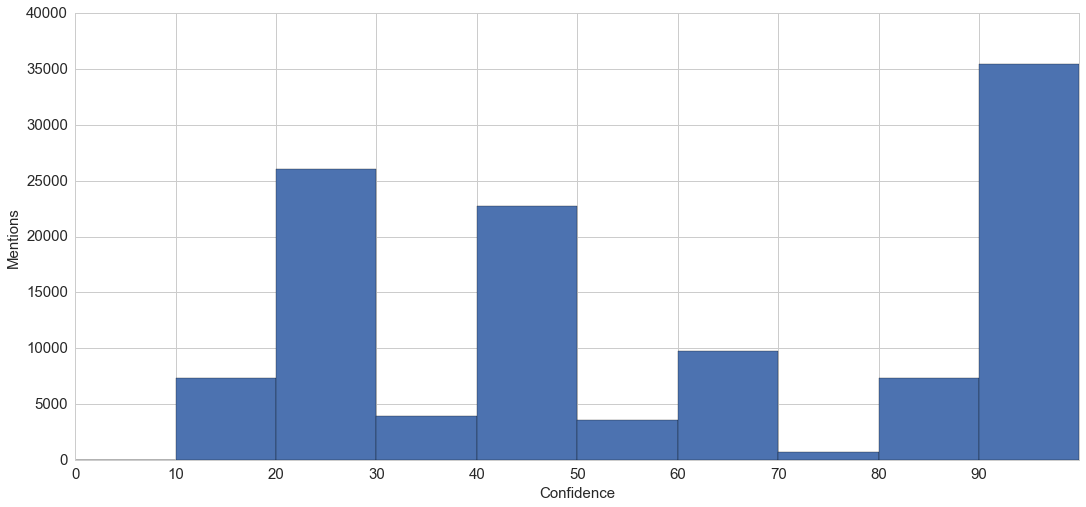

In [9]:
fig, ax = plt.subplots(figsize=(18, 8))
values = list(all_mentions.Confidence)
plt.hist(values, bins=10, range=(0,100), histtype='bar', align='mid', orientation='vertical')
ax.set_title('', fontsize=15, fontweight='bold')
ax.set_ylabel('Mentions' , fontsize=15)
ax.set_xlabel('Confidence', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xticks(np.arange(0, 100, 10))
plt.xlim([0,100])
plt.show()

## 2.6 Dominant Sources

We use the Mention Source Name (MentionSourceName) field to identify the most dominant sources, reporting the most event mentions for the duration of our study. The MentionSourceName field is a human-friendly identifier of the source of the document. For web documents with a URL (which comprise the majority of documents in our study), this field will contain the web page's top-level domain. BBC Monitoring materials will contain "BBC Monitoring" and JSTOR materials will contain "JSTOR". In the following section, we identify the most dominant sources - the top 50 sources ordered by event mentions frequency.

In [10]:
# Pre-processing: Mention Source Names
clean_names = []

for sourcename in all_mentions.MentionSourceName:
    try:
        clean_names.append(re.search('(.*?)\.', sourcename).group(1))
    except:
        clean_names.append('nan')
        
all_mentions['SourceName'] = clean_names
MentionSourceNames = Counter(clean_names).most_common(50)
mention_source_name_labels = [MentionSourceNames[i][0] for i in range(len(MentionSourceNames))]
mention_source_name_values = [MentionSourceNames[i][1] for i in range(len(MentionSourceNames))]
print(MentionSourceNames)

[('terra', 5390), ('noticias', 1680), ('contacto-latino', 1642), ('entornointeligente', 1450), ('ap', 1337), ('yahoo', 1229), ('caracol', 914), ('ntn24', 762), ('telesurtv', 729), ('eluniversal', 715), ('reuters', 701), ('vanguardia', 699), ('elpais', 672), ('eltiempo', 653), ('elespectador', 593), ('aguasdigital', 567), ('colombiareports', 532), ('telecinco', 507), ('prensa-latina', 495), ('elcomercio', 470), ('elheraldo', 434), ('oem', 426), ('wlox', 425), ('hawaiinewsnow', 415), ('rcnradio', 399), ('efe', 395), ('wradio', 390), ('radiosantafe', 387), ('informativo', 383), ('xinhuanet', 376), ('dailymail', 374), ('lainformacion', 368), ('kswo', 368), ('foxnews', 366), ('panampost', 366), ('ksby', 364), ('worldbulletin', 348), ('wn', 343), ('uol', 337), ('wandtv', 335), ('notimerica', 334), ('bbc', 328), ('wboc', 326), ('publimetro', 322), ('minuto30', 320), ('wect', 308), ('sputniknews', 295), ('dw', 295), ('lanacion', 284), ('el-carabobeno', 281)]


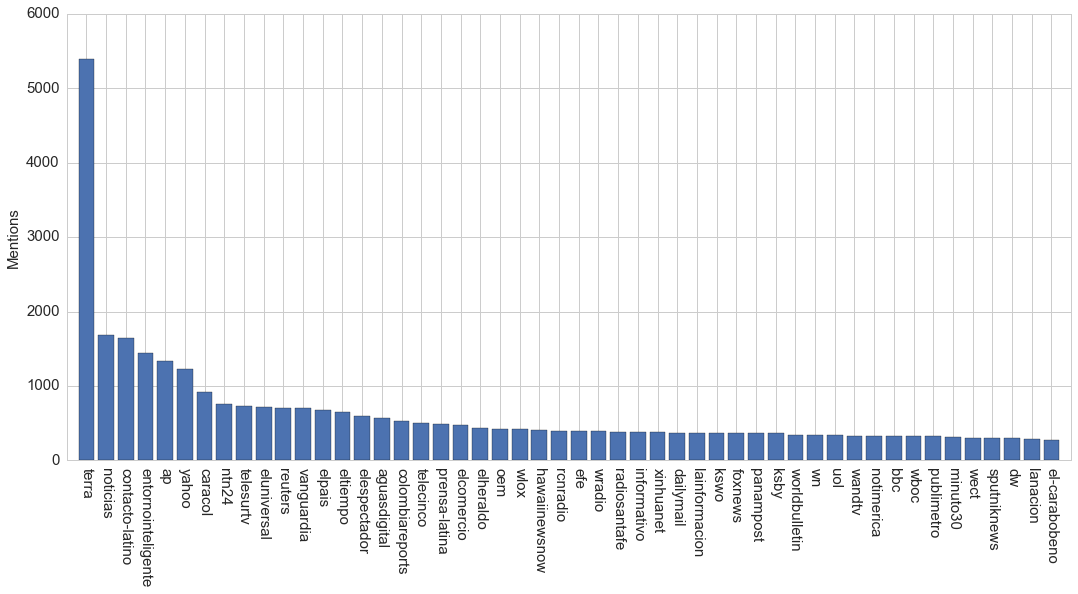

In [11]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.set_title('', fontsize=15, fontweight='bold')
ax.set_ylabel('Mentions' , fontsize=15)
ax.set_xlabel('', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.bar(np.arange(len(mention_source_name_values)), mention_source_name_values, align='center')
ax.set_xticks(np.arange(0, len(mention_source_name_labels), 1))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=270)
plt.xlim([0,len(mention_source_name_labels)])
ax.set_xticklabels(mention_source_name_labels[::1])
plt.xlim([-1,50])
plt.show()

# 3.0 Source Filtering

From the most dominant sources identified above, we performed further source filtering to identify sources currently used in the Peace Accords Matrix's (PAM) implementation monitoring and verification framework. The top 10 filtered sources are listed below:

In [12]:
# Pre-processing: Filtered Sources
filtered_names = ['ap', 'caracol', 'colombiareports', 'elcomercio', 'elespectador', 'elpais', 'eltiempo', 'eluniversal', 'noticias', 'vanguardia']
filtered_labels = ['Associated Press', 'Caracol', 'Colombia Reports', 'El Comercio', 'El Espectador', 'El Pais', 'El Tiempo', 'El Universal', 'Noticias', 'Vanguardia']

filtered_frequencies = []
for name in filtered_names:
    filtered_frequencies.append(len(all_mentions.loc[all_mentions['SourceName'] == name]))

print(OrderedDict(zip(filtered_labels, filtered_frequencies)))

OrderedDict([('Associated Press', 1337), ('Caracol', 914), ('Colombia Reports', 532), ('El Comercio', 470), ('El Espectador', 593), ('El Pais', 672), ('El Tiempo', 653), ('El Universal', 715), ('Noticias', 1680), ('Vanguardia', 699)])


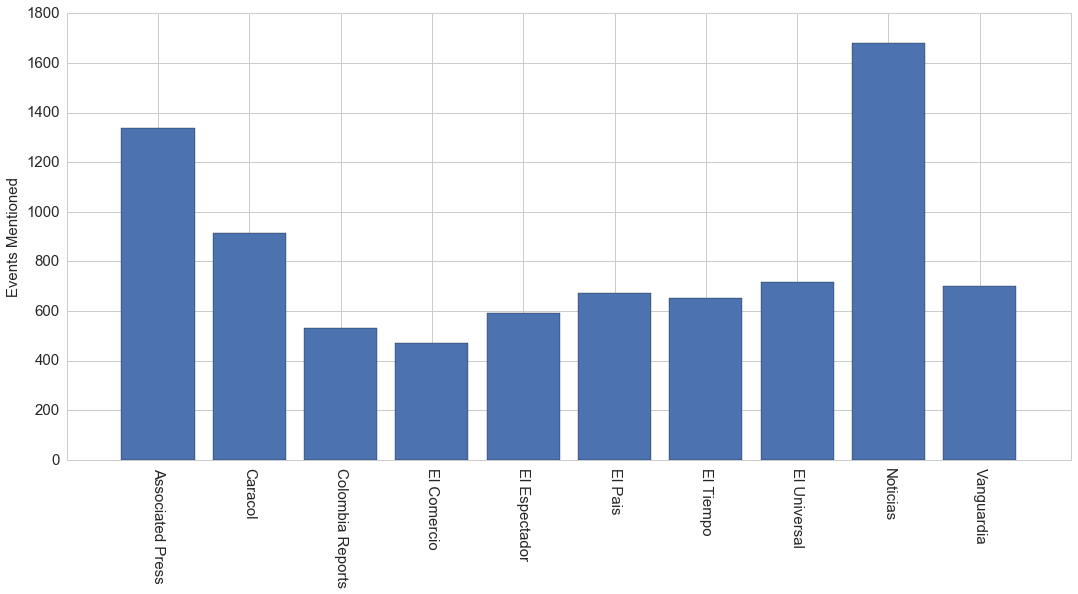

In [13]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.set_title('', fontsize=15, fontweight='bold')
ax.set_ylabel('Events Mentioned' , fontsize=15)
ax.set_xlabel('', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.bar(np.arange(len(filtered_labels)) , filtered_frequencies, align='center')
ax.set_xticks(np.arange(0, len(filtered_labels), 1))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=270)
plt.xlim([0,len(filtered_labels)])
ax.set_xticklabels(filtered_labels[::1])
plt.xlim([-1,10])
plt.show()

## 3.1 Languages Comparison

We observe that most documents from the dominant sources in our data set, with the exception of the Associated Press and Colombia Reports, are originally published in Spanish. Although GDELT Translingual claims to be the largest realtime streaming news machine translation deployment in the world providing realtime media translation into English for processing through the entire GDELT Event and GKG/GCAM pipelines, in our study, we retrieve all mention source documents in the language in which they were originally published using a native Python Newspaper library. Below is the language composition of the Top 10 filtered sources identified above.

In [14]:
for key, value in OrderedDict(zip(filtered_labels, filtered_names)).items():
    print(key+': ', Counter(all_mentions.loc[all_mentions['SourceName'] == value].Language))

Associated Press:  Counter({'English': 1337})
Caracol:  Counter({'Spanish': 914})
Colombia Reports:  Counter({'English': 532})
El Comercio:  Counter({'Spanish': 470})
El Espectador:  Counter({'Spanish': 593})
El Pais:  Counter({'Spanish': 618, 'English': 54})
El Tiempo:  Counter({'Spanish': 643, 'English': 10})
El Universal:  Counter({'Spanish': 714, 'English': 1})
Noticias:  Counter({'Spanish': 1680})
Vanguardia:  Counter({'Spanish': 699})


## 3.2 Tone Comparison

When trying to understand the particularities and commonalities of various news media, one finds that journalism is rife with varying reporting styles, ambiguities, assumed background knowledge, and complex linguistic structures. Using the MentionDocTone field from the Mentions table, we compare each news source's average tone distribution. We observe that Caracol <em>(mean=0.0, upper=2.8, lower=-2.4, std=3.9)</em>, El Tiempo <em>(-0.2, 1.7, -2.1, 2.9)</em>, and Vanguardia <em>(-0.4, 1.5, -2.6, 3.3)</em> offer balanced tones, with El Tiempo and  Vanguardia providing more moderate tone ranges compared to Caracol covering both extremes. Associated Press <em>(-2.6, -1.3, -4.4, 3.0)</em> and Colombia Reports <em>(-4.0, -1.3, -6.4, 3.8)</em> tend to provide moderately negative reporting while the remaining  sources mostly provide slightly positive or negative reporting tone.

In [15]:
#all_mentions.loc[all_mentions['SourceName'] == 'colombiareports']['MentionDocTone'].describe()

In [16]:
def compare_sources(compare_by):
    ap = list(all_mentions.loc[all_mentions['SourceName'] == 'ap'][compare_by])
    caracol = list(all_mentions.loc[all_mentions['SourceName'] == 'caracol'][compare_by])
    colombiareports = list(all_mentions.loc[all_mentions['SourceName'] == 'colombiareports'][compare_by])
    elcomercio = list(all_mentions.loc[all_mentions['SourceName'] == 'elcomercio'][compare_by])
    elespectador = list(all_mentions.loc[all_mentions['SourceName'] == 'elespectador'][compare_by])
    elpais = list(all_mentions.loc[all_mentions['SourceName'] == 'elpais'][compare_by])
    eltiempo = list(all_mentions.loc[all_mentions['SourceName'] == 'eltiempo'][compare_by])
    eluniversal = list(all_mentions.loc[all_mentions['SourceName'] == 'eluniversal'][compare_by])
    noticias = list(all_mentions.loc[all_mentions['SourceName'] == 'noticias'][compare_by])
    vanguardia = list(all_mentions.loc[all_mentions['SourceName'] == 'vanguardia'][compare_by])

    myList = [ap] + [caracol] + [colombiareports] + [elcomercio] + [elespectador] + [elpais] + [eltiempo] + [eluniversal] + [noticias] + [vanguardia]

    return myList

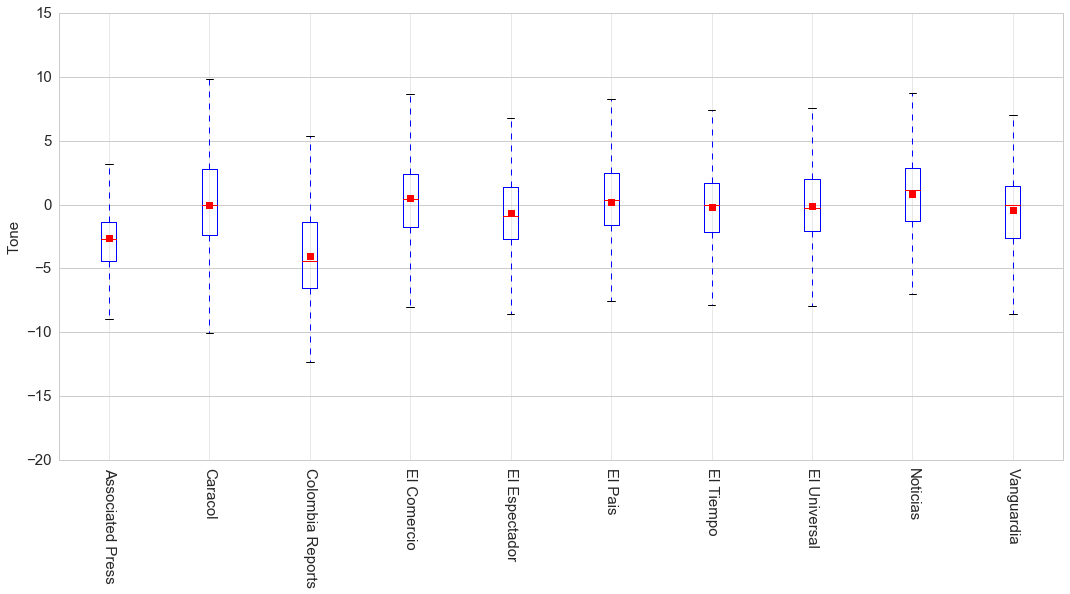

In [17]:
fig, ax = plt.subplots(figsize=(18, 8), sharex=True)
ax.set_title('', fontsize=15, fontweight='bold')
ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.set_ylabel('Tone' , fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
myList = compare_sources('MentionDocTone')
for i,l in enumerate(myList):
    ax.boxplot(l, vert=True, showfliers=True, showmeans=True, positions = [i])
ax.set_xticks(range(len(myList)))
ax.set_xticklabels(filtered_labels)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=270)
ax.set_xlim(-0.5, len(myList)-0.5)
plt.show()

## 3.3 Confidence Comparison

GDELT uses Natural Language Processing (NLP) algorithms such as coreference and deep parsing using whole-of-document context to understand and extract ambigous and linguistically complex events. Such extractions come wth a high potential for error. In this section, we compare GDELT's ability to extract an event from an article for each mention with confidence. On average, we observe high median (>80%) and upper-quartile bounds (100%) for El Comercio <em>(mean=71, std=32)</em>, El Pais <em>(67, 34)</em>, Noticias <em>(66, 32)</em>, and Vanguardia <em>(64, 36)</em> sources. Although Caracol <em>(58, 33)</em>, El Espectador <em>(55, 33)</em>, El Tiempo <em>(56, 32)</em> and El Universal <em>(56, 33)</em> have high upper-quartile bounds (100%), they have low median confidence bounds (40%). We observe low upper (50%) and median (20%) confidence scores for Associated Press <em>(38, 28)</em>.

In [18]:
#all_mentions.loc[all_mentions['SourceName'] == 'ap']['Confidence'].describe()

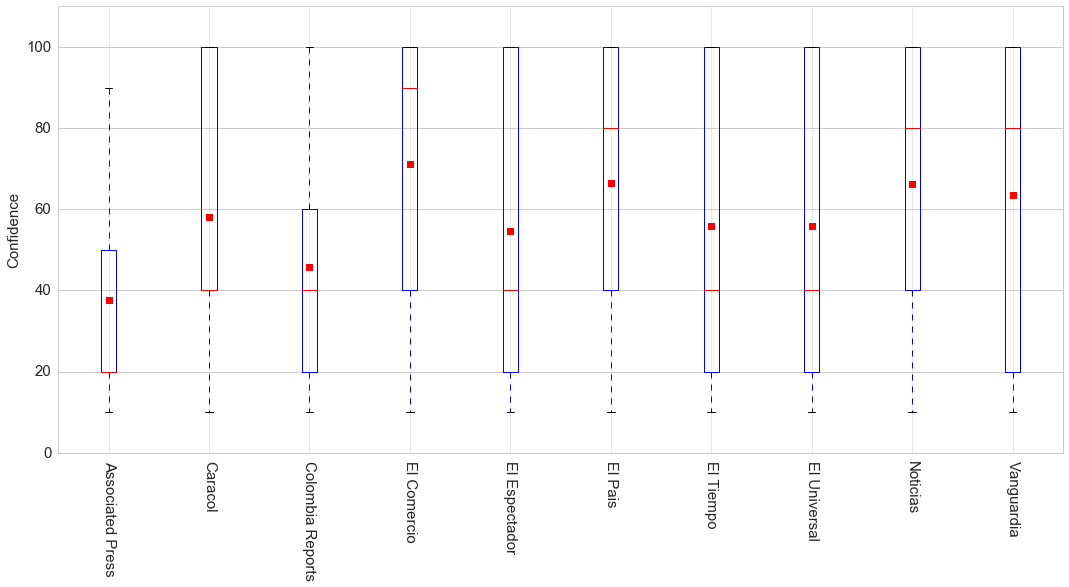

In [19]:
fig, ax = plt.subplots(figsize=(18, 8), sharex=True)
ax.set_title('', fontsize=15, fontweight='bold')
ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.set_ylabel('Confidence' , fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
myList = compare_sources('Confidence')
for i,l in enumerate(myList):
    ax.boxplot(l, vert=True, showfliers=True, showmeans=True, positions = [i])
ax.set_xticks(range(len(myList)))
ax.set_xticklabels(filtered_labels)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=270)
ax.set_xlim(-0.5, len(myList)-0.5)
ax.set_ylim(0, 110)
plt.show()